In [1]:
import numpy as np
from scipy import optimize
from scipy import stats
import matplotlib.pyplot as plt
import math
from scipy.special import factorial

# MLE for normally distributed data

Let's walk through an example of using MLE to estimate the parameters for the distribution of some sample data. To start, let's [simulate some data from a normal distribution](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html) with known parameters, which we will refer to as $\mathbf{x}$.

In [2]:
MU = 4
SIGMA = 3
N = 1000
norm_sample = stats.norm.rvs(loc = MU, scale = SIGMA, size = N)

### Visualize
Let's take a look at what our sample data looks like.

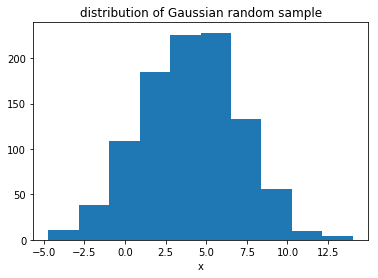

In [3]:
plt.hist(norm_sample)
plt.xlabel('x')
plt.title('distribution of Gaussian random sample')
plt.show()

### Define likelihood function

As you recall, the [likelihood function for a continuous distribution](https://en.wikipedia.org/wiki/Likelihood_function#Continuous_probability_distribution) such as this one:

$$\mathcal{L}(\theta\mid \mathbf{x})=f_{\theta}(\mathbf{x})=P_{\theta}(X=\mathbf{x})$$
or,
$$\mathcal{L}(\theta\mid \mathbf{x})=\prod_{i=1}^{N} f_{\theta}(x_i) = \prod_{i=1}^{N} P_{\theta}(X=x_i).$$

$f_{\theta}(x_i)=P_{\theta}(X=x)$ is essentially another way of writing the PDF for the continuous distribution given the parameterization $\theta$. 

Here, because we are fitting the data to a [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution), $\theta=[\mu,\sigma]$. The PDF for the normal distribution is defined as:

$$f_{\mu,\sigma}(x)=f(x\mid\mu,\sigma)=\frac{1}{\sqrt{2\pi\sigma^2}}\exp{\left(-\frac{(x-\mu)^2}{2\sigma^2}\right)}.$$

In practice, it is more common to optimize over the log-likelihood, because the product of many probability values can lead to floating point errors in computation:

$$\log (\mathcal{L}(\theta\mid \mathbf{x}))=\sum_{i=1}^{N} \log (f_{\theta}(x_i)) = \sum_{i=1}^{N} \log (P_{\theta})(X=x_i).$$

### Optimize 

Many built-in optimizers don't have a maximization function, only a minimization function. Therefore, instead of maximizing the log-likelihood, we will minimize the negative log-likelihood.

In [4]:
# define negative log-likelihood function
def ll_norm(params, x):
    '''params is a list of parameters to estimate: [mu, sigma]
    x is list of normally distributed values described by estimated params'''
    
    mu = params[0]
    sigma = params[1]
    loglik = np.log((1/((2*math.pi*sigma**2)**0.5))*np.exp(-((x-mu)**2)/(2*sigma**2)))
    return -loglik.sum()

##### Quick intro to essential arguments for [`scipy.optimize.minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html):
- `fun`: function to minimize
- `x0`: initial guesses for parameters to estimate, in the form of a list, tuple, or numpy array
- `args`: any other variables to pass to the function, given in a list, tuple, or numpy array
- `bounds`: bounds for parameters to be estimated, given as a list of lists or tuple of tuples, corresponds to params in `x0`

In [5]:
# minimize negative log-likelihood
norm_res = optimize.minimize(fun = ll_norm,
              x0 = [0,1],
              args = (norm_sample),
            bounds = ((None,None),(1e-6,None)))

norm_res

      fun: 2509.8651698184385
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00040927, -0.00027285])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 45
      nit: 14
   status: 0
  success: True
        x: array([4.02069038, 2.97703045])

##### Interpreting the results 
- `fun`: minimum value of function at estimated parameters
- `nfev`: number of function evaluations
- `nit`: number of iterations
- `success`: bool - did the optimizer run into an issue?
- `x`: array of estimated parameters that minimize the function, corresponding to `x0`

In [6]:
print('mu = %d, sigma = %d' % (MU, SIGMA))
print('mu_est = %.4f, sigma_est = %.4f' % (norm_res.x[0], norm_res.x[1]))

mu = 4, sigma = 3
mu_est = 4.0207, sigma_est = 2.9770


How do the estimated parameters $\hat\mu$ and $\hat\sigma$ compare to the actual parameter values used to generate the sample data? How will changing the size of the sample affect the precision of the estimation? 

# MLE for Poisson distributed data

Now let's see how we can use MLE to estimate the parameters of the distribution from which a set of [Poisson distributed data](https://en.wikipedia.org/wiki/Poisson_distribution) came from. Poisson-distributed data is discrete and nonnegative. The Poisson distribution takes only one parameter, $\lambda>0$, which represents the rate at which events occur. 

It is a discrete probability distribution that expresses the probability of a given number of events, $k$, occurring in a fixed interval of time or space, if the events occur with a known constant rate $\lambda$ and independently of the time since the last event. 

Here, we will randomly generate a set of Poisson distributed data for a specified value of $\lambda$.

Note: The [scipy notation for the Poisson distribution](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.poisson.html) uses $\mu$ in place of $\lambda$!

In [7]:
LAMBDA = 0.5
N = 1000
poisson_sample = stats.poisson.rvs(mu = LAMBDA, size = N)

### Visualize

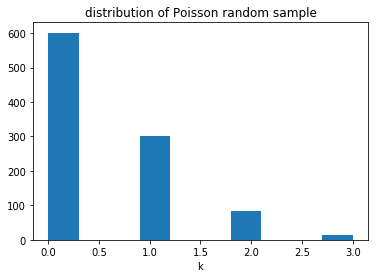

In [8]:
plt.hist(poisson_sample)
plt.xlabel('k')
plt.title('distribution of Poisson random sample')
plt.show()


### Define likelihood function

For a [discrete distribution](https://en.wikipedia.org/wiki/Likelihood_function#Discrete_probability_distribution) such as the Poisson, the likelihood function doesn't change much, except it takes the products of the probability mass functions (PMF) rather than the probability distribution function (PDF):

$$\mathcal{L}(\theta\mid \mathbf{x})=p_{\theta}(\mathbf{x})=P_{\theta}(X=\mathbf{x})$$
or,
$$\mathcal{L}(\theta\mid \mathbf{x})=\prod_{i=1}^{N} p_{\theta}(x_i) = \prod_{i=1}^{N} P_{\theta}(X=x_i).$$

Again, we will need to define the [PMF for the Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution#Probability_of_events_for_a_Poisson_distribution) to define our likelihood function. Because the Poisson is parameterized by $\lambda$, $\theta=[\lambda]$ for our likelihood function.
$$p_{\lambda}(k)=p(k \mid \lambda)=\exp^{-\lambda}\frac{\lambda^k}{k!}$$

Again, we will minimize over the negative log-likelihood function. The log-likelihood function for the Poisson is expressed as:
$$\log (\mathcal{L}(\theta\mid \mathbf{k}))=\sum_{i=1}^{N} \log (p_{\theta}(k_i)) = \sum_{i=1}^{N} \log (P_{\theta}(X=k_i))$$

In [9]:
def ll_pois(params, k):
    '''params is list of parameters to estimate: [lambda]
    k is list of Poisson distributed values described by estimated parameter'''
    
    lmbd = params[0]
    loglik = np.log(np.exp(-lmbd)*(lmbd**k)/factorial(k))
    return -loglik.sum()

Note: When you want to set bounds but you only have one parameter to estimate, you need to format it as demonstrated below, or you will run into an error.

In [10]:
pois_res = optimize.minimize(fun = ll_pois,
              x0 = [1e-6],
              args = (poisson_sample),
            bounds = ((1e-6,None),))

pois_res

      fun: 937.3870827020155
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.0001819])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 56
      nit: 17
   status: 0
  success: True
        x: array([0.51099991])

In [11]:
print('lambda = %.1f' % LAMBDA)
print('lambda_est = %.4f' % pois_res.x[0])

lambda = 0.5
lambda_est = 0.5110


scipy has built-in [pdf](https://docs.scipy.org/doc/scipy-1.1.0/reference/generated/scipy.stats.rv_continuous.pdf.html) and [logpdf](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.logpdf.html) functions for a number of distributions, so in practice you could use those functions instead of implementing them yourself.